# Lab 1 : First order methods on regression models

#### Authors: A. Gramfort, R. Gower, P. Ablin

## Aim

The aim of this material is to code 
- proximal gradient descent (ISTA)
- accelerated gradient descent (FISTA) 

for 
- linear regression
- logistic regression 

models.

The proximal operators we will use are the 
- ridge penalization
- L1 penalization

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 7th of october at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 2 octobre 2017**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [72]:
# Change here using YOUR first and last names
fn1 = "benjamin"
ln1 = "lazard"
fn2 = "côme"
ln2 = "cothenet"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab1", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab1_lazard_benjamin_and_cothenet_côme.ipynb


In [73]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

### Getting sparse coefficients

In [74]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

Text(0.5,1,'Parameters / Coefficients')

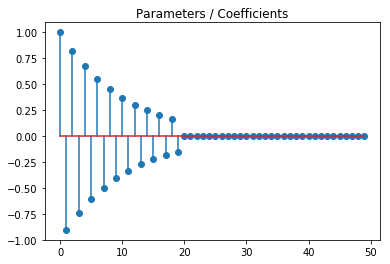

In [75]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = ((-1) ** idx) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [76]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn

def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + randn(n_samples)
    return A, b

def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))

def simu_logreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A.dot(coefs))
    b = np.random.binomial(1, p, size=n_samples)
    b = 2 * b - 1
    return A, b

## Part 1 : Proximal operators

We remind that the proximal operator of a fonction $g$ is given by:

$$
\text{prox}_g(x) = \arg\min_z \left\{ \frac{1}{2} \Vert x - z\Vert_2^2 + g(z) \right\}.
$$


We have in mind to use the following cases

- Ridge penalization, where $g(z) = \frac{s}{2} \|z\|_2^2$
- Lasso penalization, where $g(z) = s \|z|\|_1$

where $s \geq 0$ is a regularization parameter.

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Code a function that computes $g(x)$ in both cases and $\text{prox}_g(x)$ for ridge and  lasso penalization (use the slides of the first course to get the formulas), using the prototypes given below</li>
      <li>Visualize the functions applied element wise by the proximity operators of the Ridge and Lasso 
    </li>
    </ul>
</div>

In [77]:
def prox_lasso(x, s):
    """Proximal operator for the Lasso at x"""
    return np.sign(x) * np.maximum((np.abs(x) - s), 0)
        
def lasso(x, s):
    """Value of the Lasso penalization at x"""
    return s*np.linalg.norm(x, ord=1)

def prox_ridge(x, s):
    """Proximal operator for the ridge at x"""    
    return x / (1. + s)

def ridge(x, s):
    """Value of the ridge penalization at x"""
    return s/2 * np.linalg.norm(x, ord=2)

## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

(-2, 2)

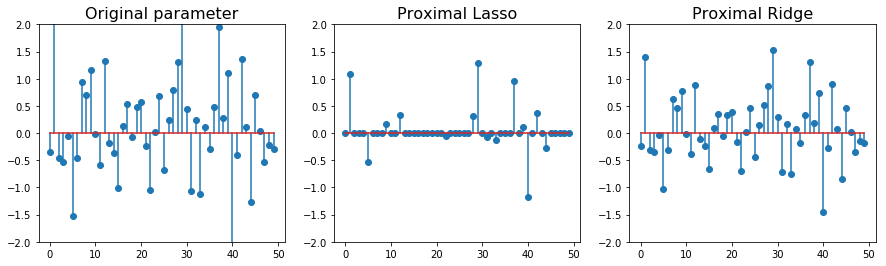

In [78]:
x = randn(50)
l_l1 = 1.
l_l2 = 0.5

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_lasso(x, s=l_l1))
plt.title("Proximal Lasso", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_ridge(x, s=l_l2))
plt.title("Proximal Ridge", fontsize=16)
plt.ylim([-2, 2])

<div class="alert alert-success">
    <b>Question</b>:
     <ul>
      <li>Comment what you observe (1 or 2 sentences).</li>
    </ul>
</div>

<div class="alert alert-warning">
    <b>Answer</b>:
     <ul>
        <h5> Let's recap what we observe</h5>
        <p> We have 50 features, each with random coefficients provided by the vector x.</p>
        <h5>Impact of proximal operator using Lasso penalization</h5>
        <p> The Lasso provides a sparse vector. Only the "most significant" coefficients are kept, all the others being zeroed out. "Most significant" is actually defined relatively to the parameter *s* provided: we keep only coefficients bigger than s in absolute value, and substract s.</p>
        <h5>Impact of proximal operator using Ridge penalization</h5>
        <p> Ridge provides a scaled down vector. The scale is 1/(1+s) where s>0</p>
    </ul>
</div>

We can better understand the proximal operator, by observing its effect when x is a real:

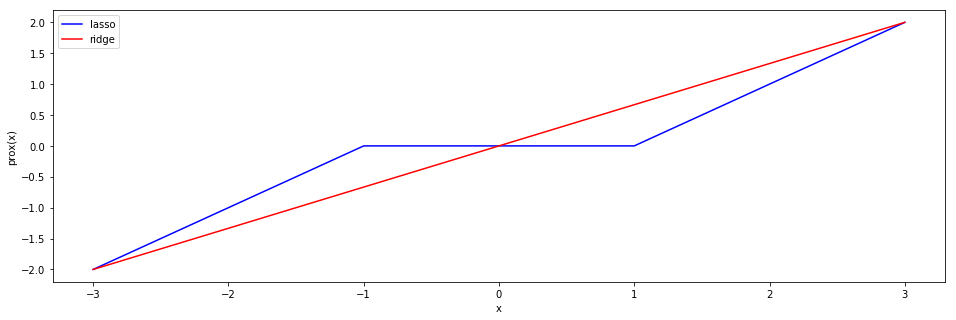

In [79]:
x = np.arange(start=-3, stop=4, step=1)
s = 1.
y_lasso = prox_lasso(x, s)
y_ridge = prox_ridge(x, s/2)

plt.figure(figsize=(16,5))
plt.plot(x, y_lasso, 'b-', label="lasso")
plt.plot(x, y_ridge, 'r-', label="ridge")
plt.legend()
plt.xlabel("x")
plt.ylabel("prox(x)")
plt.show()

del x, y_lasso, y_ridge

## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + g(x)
$$
where $f$ is $L$-smooth and $g$ is prox-capable.

Consider the following cases:

**Linear regression**, where 
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A$ is the matrix of features.

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute on paper the gradient $\nabla f$ of $f$ for both cases (linear and logistic regression)</li>
      <li>Code a function that computes $f$ and its gradient $\nabla f$ in both cases, using the prototypes below.</li>
      <li>Check that these functions are correct by numerically checking the gradient, using the function 
          <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.check_grad.html">check_grad</a> from ``scipy.optimize``. Remark: use the functions `simu_linreg` and `simu_logreg` to simulate data according to the right model</li>
    </ul>
</div>

<div class="alert alert-warning">
    <b>Answer</b>:
     <ul>
        <h5> Let's compute the gradient for the linear regression</h5>
    </ul>
</div>

$$\nabla_x f(x) \left( \approx \frac{\partial \frac{1}{2n}{\left\lVert Ax-b\right\rVert}^2}{\partial x} \right) = \frac{1}{n}A^T(Ax-b)$$

<div class="alert alert-warning">
    <b>Answer</b>:
     <ul>
        <h5> Let's compute the gradient for the logistic regression</h5>
    </ul>
</div>

$$
\frac{\partial f(x)}{\partial x_k} = \frac{\partial}{\partial x_k} \left( \frac{1}{n} \sum\limits_{i=1}^{n}{log\left( 1 + e^{-b_ia_i^Tx}\right)} \right) 
= \frac{1}{n} \sum\limits_{i=1}^{n} \frac{\partial {log\left( 1 + e^{-b_ia_i^Tx}\right)}}{\partial x_k}
= \frac{1}{n} \sum\limits_{i=1}^{n} \frac{\frac{\partial}{\partial x_k} {\left( 1 + e^{-b_i\sum\limits_{j=1}^m a_{ij}x_j}\right)}}{\left( 1 + e^{-b_ia_i^Tx}\right)}
= \frac{1}{n} \sum\limits_{i=1}^{n} \frac{-b_ia_{ik}e^{-b_ia_i^Tx}}{\left( 1 + e^{-b_ia_i^Tx}\right)}
$$

This yields (multiplying numerator and denominator by $e^{b_ia_i^Tx}$):

$$
\nabla_x f(x) = \left( \frac{1}{n} \sum\limits_{i=1}^{n} \frac{-b_ia_{ik}}{\left( 1 + e^{b_ia_i^Tx}\right)} \right)_{k \in [1,m]}
$$

In [80]:
def loss_linreg(x, A, b):
    """Least-squares loss"""
    n = np.size(b)
    return np.linalg.norm(np.dot(A,x) - b)**2 /2 /n

def grad_linreg(x, A, b):
    """Leas-squares gradient"""
    n = np.size(b)
    return 1/n * np.dot(A.T, np.dot(A, x) - b)

def loss_logreg(x, A, b):
    """Logistic loss"""
    n = np.size(b)
    loss = np.dot(A, x)
    loss =  -b * loss
    loss = np.log( 1 + np.exp(loss))
    return np.mean(loss)

def grad_logreg(x, A, b):
    """Logistic gradient"""
    n = np.size(b)
    
    # So as to make computation more efficient, we use numpy operations whenever possible.
    # First, we compute the terms -bi*aik from the sum above and store it in a matrix. "i" is on the line dimension, 
    # and "k" is on the column dimension
    grad = -b * A.T
    # Then we compute the denominator from the sum as a numpy vector.
    exp_terms = 1 + np.exp(b * np.dot(A, x))
    grad = grad / exp_terms # element-wise division along the "i" axis
    
    # Eventually, we make the sum from the gradient expression along the lines "i" (sum the columns together) 
    # to get the gradient vector (that is the "k" axis)
    return np.sum(grad, axis=1)/n

In [81]:
from scipy.optimize import check_grad

x = randn(50)

A,b = simu_linreg(coefs)
print("linear regression gradient computation error is %s "% check_grad(lambda x: loss_linreg(x, A, b), lambda x: grad_linreg(x, A, b), x))

A,b = simu_logreg(coefs)
print("Logistic regression gradient computation error is %s "% check_grad(lambda x: loss_logreg(x, A, b), lambda x: grad_logreg(x, A, b), x))

linear regression gradient computation error is 3.4376200882489925e-06 
Logistic regression gradient computation error is 1.3516656686244508e-07 


## Part 3: Solvers

We know have a function to compute $f$, $\nabla f$ and $g$ and $\text{prox}_g$. 

We want now to code the Ista and Fista solvers to minimize

$$
\arg\min_x f(x) + g(x)
$$

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Implement functions that compute the Lipschitz constants for linear and 
  logistic regression losses. Note that the operator norm of a matrix can 
  be computed using the function <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html">numpy.linalg.norm</a> (read the documentation
  of the function)</li>
      <li>Finish the functions `ista` and `fista` below that implements the 
  ISTA (Proximal Gradient Descent) and FISTA (Accelerated Proximal 
  Gradient Descent) algorithms</li>
    </ul>
</div>

<div class="alert alert-warning">
    <b>Answer</b>:
     <ul>
        <h5> Let's compute the Lipschitz constants for the Linear Regression</h5>
    </ul>
</div>

Let us call $L$ the smoothness constant of the function considered. As proved in the course, we can take gradient-descent steps $w_{t+1} = w_t - \frac{1}{L}\nabla f(w_t)$

$$\left\lVert \nabla f(x) - \nabla f(y)\right\rVert 
= \left\lVert \frac{1}{n}(A^TAx -b) - \frac{1}{n}(A^TAy -b)\right\rVert 
= \left\lVert \frac{1}{n}A^TA(x-y)\right\rVert 
\leq \frac{1}{n}\lVert A\rVert_2^2 \left\lVert x - y\right\rVert$$

Hence we can take $L = \frac{1}{n}\lVert A\rVert_2^2$ where $\lVert A\rVert_2 = \sigma_{max}(A)$.

<div class="alert alert-warning">
    <b>Answer</b>:
     <ul>
        <h5> Let's compute the Lipschitz constants for the Logistic Regression</h5>
    </ul>
</div>

Finding $L$ is harder for the logistic regression.
We will use the following results, proved in the $1^st$ homework sheet related to this course:
Given a function $f : R^d\mapsto R^d$ $L$-smooth and a set of functions $f_i : R^d\mapsto R$ $L_i$-smooth as well
- the function $g : x\mapsto f(Ax +b)$, $g$ is $L\lVert A\rVert^2_2$-smooth
- the function $g : x\mapsto \frac{1}{n}\sum f_i(x)$, $g$ is $\frac{1}{n}\sum L_i$-smooth

Let us consider $f : x\in R \mapsto log(1 + e^x)$.
We have that $f^{''}(x) = \frac{e^x}{(1+e^x)^2}$. We have $(1 -e^x)^2 \geq 0 \Longleftrightarrow 1 + e^{2x} \geq 2e^x \Longleftrightarrow 1 + e^{2x} + 2e^x\geq 4e^x \Longleftrightarrow (1 + e^{x})^2 \geq 4e^x \Longleftrightarrow \frac{e^x}{(1 + e^{x})^2}  = f^{''}(x) \leq \frac{1}{4}$

Using the 2 rules above, we can take $L = \frac{1}{4n}\lVert A\rVert^2_2$ for the logistic regression with the lines of $A$ being the $a_i$ from the logistic regression formula.

In [82]:
from numpy.linalg import norm as norm

def lip_linreg(A):
    """Lipschitz constant for linear squares loss"""
    L  = np.linalg.norm(A, ord=2)
    return L**2 / len(A)
    
def lip_logreg(A):
    """Lipschitz constant for logistic loss"""    
    return lip_linreg(A) / 4.
    
def ista(x0, f, grad_f, g, prox_g, L, λ=0., n_iter=50,
         x_true=coefs, A=A, verbose=True):
    """Proximal gradient descent algorithm
        (Iterative Shrinkage-Thresholding Algorithm)
    """
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, λ)
    objectives.append(obj)
    if verbose:
        print("Lauching ISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):
        
        x_new = prox_g(x - grad_f(x)/L, λ/L)
        x = x_new 
        
        obj = f(x) + g(x, λ)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

In [83]:
def fista(x0, f, grad_f, g, prox_g, L, λ=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Accelerated Proximal gradient descent algorithm
      (Fast Iterative Shrinkage-Thresholding Algorithm)
    """
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for FISTA
    z = x0.copy()
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, λ)
    objectives.append(obj)
    β = 1.
    β_new = 1.    
    if verbose:
        print("Lauching FISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        x_new = prox_g(z - grad_f(z)/L, λ/L)
        β_new = (1 + (1 + 4 * β**2)**.5) / 2
        z = x_new + (β - 1) / β_new * (x_new - x)
        
        x, β = x_new, β_new

        obj = f(x) + g(x, λ)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors)

## Algorithms comparison and numerical experiments

In [84]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 40
λ = 1e-2

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute a precise minimum and a precise minimizer of the linear regression with ridge 
  penalization problem using the parameters given above. This can be done by using fista with 
  1000 iterations.</li>
    <li>Compare the convergences of ISTA and FISTA, in terms of distance to the minimum and 
  distance to the minimizer. Do your plots using a logarithmic scale of the y-axis.</li>
    </ul>
</div>

In [85]:
A,b = simu_linreg(coefs)
L = lip_linreg(A)
f = lambda x: loss_linreg(x, A, b)
grad_f = lambda x: grad_linreg(x, A, b)
verbose = False

x_min, obj_min, err_min = fista(x0=x0, f=f, grad_f=grad_f, g=ridge, prox_g=prox_ridge, L=L, λ=λ, n_iter=1000, x_true=coefs, verbose=verbose)
print("We find err=%s with a convergence happening on the first steps"% err_min[-1])

We find err=0.14261887322390576 with a convergence happening on the first steps


Let us define the minimum $x_{fista}$  found at the last run of the algorithm as the objective to be found by both algorithm starting from $x_0$, to better compare their performances

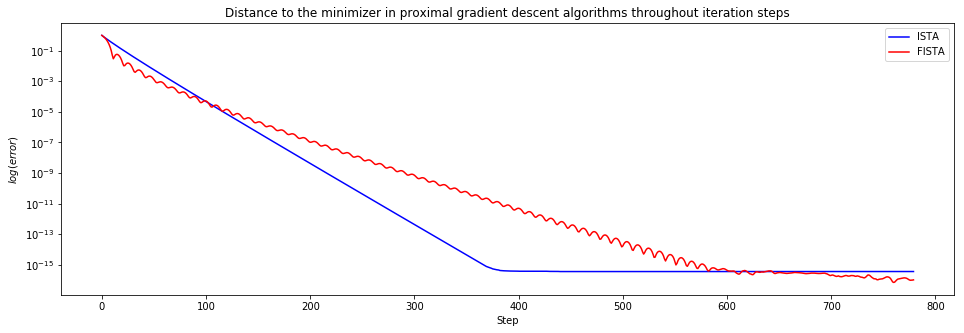

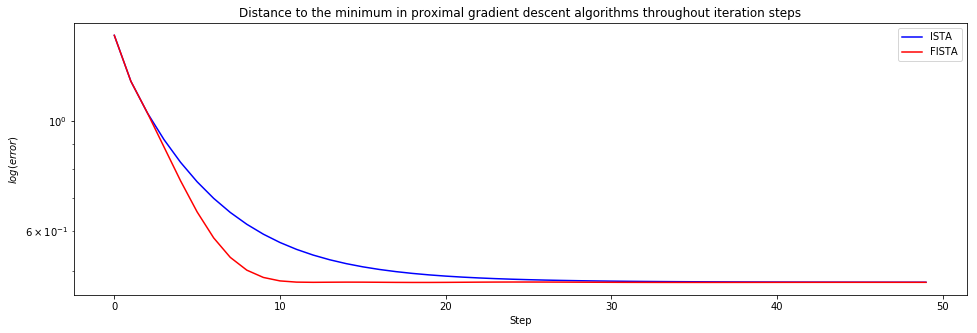

In [86]:
x_fista, obj_fista, err_fista = fista(x0=x0, f=f, grad_f=grad_f, g=ridge, prox_g=prox_ridge, L=L, λ=λ, n_iter=1000, x_true=x_min, verbose=verbose)
x_ista, obj_ista, err_ista = ista(x0=x0, f=f, grad_f=grad_f, g=ridge, prox_g=prox_ridge, L=L, λ=λ, n_iter=1000, x_true=x_min, verbose=verbose)

# Plot for the minimizer
# Convergence happens very fast: plotting the last iterations of the algorithm is not very 
# explanatory as the error stops decreasing past the 100th step
n_max = 780
plt.figure(figsize=(16, 5))
plt.plot(range(n_max), err_ista[:n_max], 'b-', label="ISTA")
plt.plot(range(n_max), err_fista[:n_max], 'r-', label="FISTA")
plt.legend()
plt.xlabel("Step")
plt.ylabel("$log(error)$")
plt.title("Distance to the minimizer in proximal gradient descent algorithms throughout iteration steps")
plt.yscale('log')
plt.show()

# Plot for the objective function of the minimizer ( the minimum)
n_max = 50
plt.figure(figsize=(16, 5))
# plt.plot(range(n_max), np.log(np.abs(obj_ista[:n_max] - obj_ista[-1])), 'b-', label="ISTA")
# plt.plot(range(n_max), np.log(np.abs(obj_fista[:n_max] - obj_fista[-1])), 'r-', label="FISTA")
plt.plot(range(n_max), np.abs(obj_ista[:n_max]), 'b-', label="ISTA")
plt.plot(range(n_max), np.abs(obj_fista[:n_max]), 'r-', label="FISTA")
plt.legend()
plt.xlabel("Step")
plt.ylabel("$log(error)$")
plt.title("Distance to the minimum in proximal gradient descent algorithms throughout iteration steps")
plt.yscale("log")
plt.show()

<div class="alert alert-warning">
    <b>Answer</b>:
     <ul>
        <h5> Comparing speed</h5>
        <p> FISTA gets closer to the solution faster: it takes about 15 steps to FISTA to get to the minimum of the objective function, as opposed to 30-40 steps for ISTA.</p>
        <h5>Comparing minimizer output</h5>
        <p> There seems to be some sort of instability around the minimizer for the FISTA. ISTA guarantees that at each step, the value of the minimizer found is better than the one from the former step, whereas FISTA error function, although converging as well, is not monotonic. <br> We also notice that after about a 100 steps, ISTA becomes faster than FISTA... But it does not really change the fact that FISTA is better overall, since past step 40, the objective function does not really decrease anyway.  </p><a href=https://arxiv.org/pdf/1501.02888.pdf>see this source for more explanations</a>
    </ul>
</div>

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Compare the solution you obtain with ista and fista with the true parameter `coefs` of
  the model. This can be done with `plt.stem` plots.</li>
    <li>In linear regression and logistic regression, study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.</li>
    <li>In linear regression and logistic regression, study the influence of the level of ridge 
  penalization on the performance of the optimization algorithms. Explain.</li>
    <li>In linear regression and logistic regression, compare the performance of the optimization
  algorithms for ridge and lasso penalizations. Explain</li>
    </ul>
</div>

<div class="alert alert-warning">
    <b>Answer</b>:
     <ul>
        <h5> Impact of coefs</h5>
        <p> See the last question</p>
    </ul>
</div>

Let us study the impact of the correlation.
The code below is ugly and not interesting, **please skip directly to the chart it outputs.**

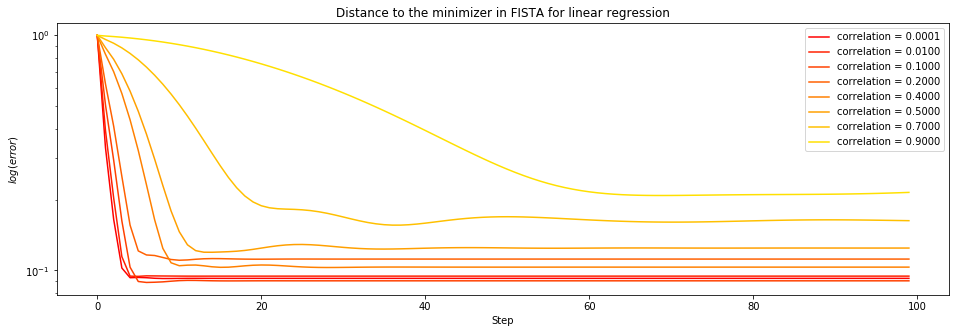

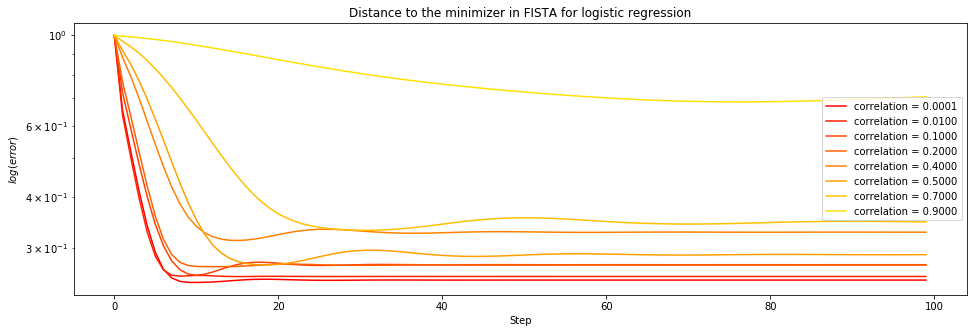

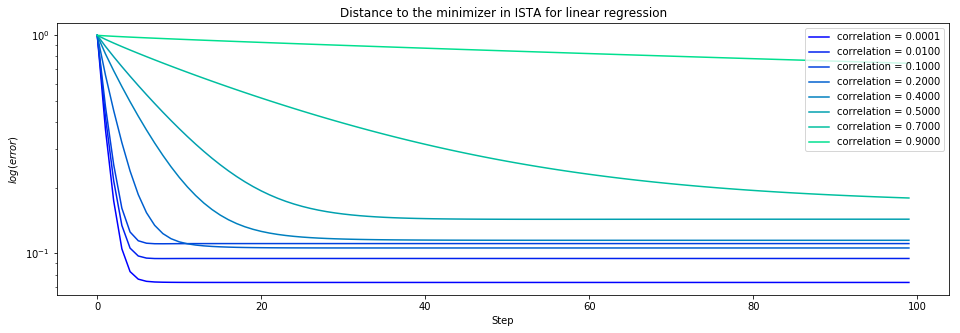

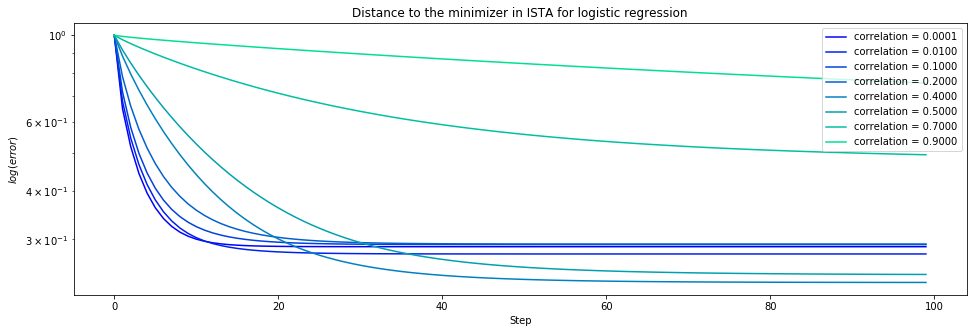

In [87]:
# correlations = np.logspace(start=-5, stop=-.1, base=10.0, num=8)
correlations = [0.0001, 0.01, 0.1, 0.2, 0.4, 0.5, 0.7, 0.9]
verbose = False

cm = plt.get_cmap("autumn")
colors = [cm(x) for x in np.arange(start=0, stop=1, step= 1./len(correlations))]
n_max = 100

##########################################################################
# FISTA
##########################################################################

# Linear Regression and FISTA
plt.figure(figsize=(16, 5))
for i, correlation in enumerate(correlations):
    A,b = simu_linreg(coefs, corr = correlation)
    L = lip_linreg(A)
    f = lambda x: loss_linreg(x, A, b)
    grad_f = lambda x: grad_linreg(x, A, b)
    
    _, _, err_fista = fista(x0=x0, f=f, grad_f=grad_f, g=ridge, prox_g=prox_ridge, L=L, λ=λ, n_iter=1000, x_true=coefs, verbose=verbose)
    plt.plot(range(n_max), err_fista[:n_max], '-', label="correlation = " + "%0.4f"%correlation, color=colors[i])

plt.legend()
plt.xlabel("Step")
plt.ylabel("$log(error)$")
plt.title("Distance to the minimizer in FISTA for linear regression")
plt.yscale("log")
plt.show()


# Logistic Regression and FISTA
plt.figure(figsize=(16, 5))
for i, correlation in enumerate(correlations):
    A,b = simu_logreg(coefs, corr = correlation)
    L = lip_logreg(A)
    f = lambda x: loss_logreg(x, A, b)
    grad_f = lambda x: grad_logreg(x, A, b)
    
    _, _, err_fista = fista(x0=x0, f=f, grad_f=grad_f, g=ridge, prox_g=prox_ridge, L=L, λ=λ, n_iter=1000, x_true=coefs, verbose=verbose)
    plt.plot(range(n_max), err_fista[:n_max], '-', label="correlation = " + "%0.4f"%correlation, color=colors[i])

plt.legend()
plt.xlabel("Step")
plt.ylabel("$log(error)$")
plt.title("Distance to the minimizer in FISTA for logistic regression")
plt.yscale("log")
plt.show()

##########################################################################
# ISTA
##########################################################################
cm = plt.get_cmap("winter")
colors = [cm(x) for x in np.arange(start=0, stop=1, step= 1./len(correlations))]

# Linear Regression and ISTA
plt.figure(figsize=(16, 5))
for i, correlation in enumerate(correlations):
    A,b = simu_linreg(coefs, corr = correlation)
    L = lip_linreg(A)
    f = lambda x: loss_linreg(x, A, b)
    grad_f = lambda x: grad_linreg(x, A, b)
    
    _, _, err_ista = ista(x0=x0, f=f, grad_f=grad_f, g=ridge, prox_g=prox_ridge, L=L, λ=λ, n_iter=1000, x_true=coefs, verbose=verbose)
    plt.plot(range(n_max), err_ista[:n_max], '-', label="correlation = " + "%0.4f"%correlation, color=colors[i])

plt.legend()
plt.xlabel("Step")
plt.ylabel("$log(error)$")
plt.title("Distance to the minimizer in ISTA for linear regression")
plt.yscale("log")
plt.show()


# Logistic Regression and ISTA
plt.figure(figsize=(16, 5))
for i, correlation in enumerate(correlations):
    A,b = simu_logreg(coefs, corr = correlation)
    L = lip_logreg(A)
    f = lambda x: loss_logreg(x, A, b)
    grad_f = lambda x: grad_logreg(x, A, b)
    
    _, _, err_ista = ista(x0=x0, f=f, grad_f=grad_f, g=ridge, prox_g=prox_ridge, L=L, λ=λ, n_iter=1000, x_true=coefs, verbose=verbose)
    plt.plot(range(n_max), err_ista[:n_max], '-', label="correlation = " + "%0.4f"%correlation, color=colors[i])

plt.legend()
plt.xlabel("Step")
plt.ylabel("$log(error)$")
plt.title("Distance to the minimizer in ISTA for logistic regression")
plt.yscale("log")
plt.show()

<div class="alert alert-warning">
    <b>Answer</b>:
     <ul>
        <h5> Impact of the correlation of the features</h5>
        <p> For the ridge regression, we observe on average that the higher the correlation is, the higher is the final error, and the slower is the algorithm. The type of the regression and the choice of the proximal gradient algorithm matters not. 
           <br>  <br>We suggest the following explanation:</p>
    </ul>
</div>

- Let us assume we have a simple model where we have 2 features : $x = (x_1, x_2)$ and we try to predict the label with a linear model on it: $y = a_0 + a_1x_1 + a_2x_2$
- Let us assume that there is a strong correlation between $x_1$ and $x_2$... so strong that $x_1 = c x_2$ where c is a constant.

Then the model would lead to the exact same predictions with any of the $ a = (a_1, a_2)$ such that  $a_1c + a_2$ is a constant because $y = a_0  + a_1x_1 + a_2x_2 = a_0  + a_1cx_2 + a_2x_2 = a_0  + (a_1c + a_2)x_2$. There is of course an infinty of such vectors $a$ and because of that the model is somehow unstable.

Because of that, linear models are not very performant in case of high correlations between features. The reasoning is similar for logistic regressions.

[helpful source](https://stats.stackexchange.com/questions/250376/feature-correlation-and-their-effect-of-logistic-regression)

____
Let us study the impact of the level of ridge penalization.
The code below is ugly and not interesting, **please skip directly to the chart it outputs.**

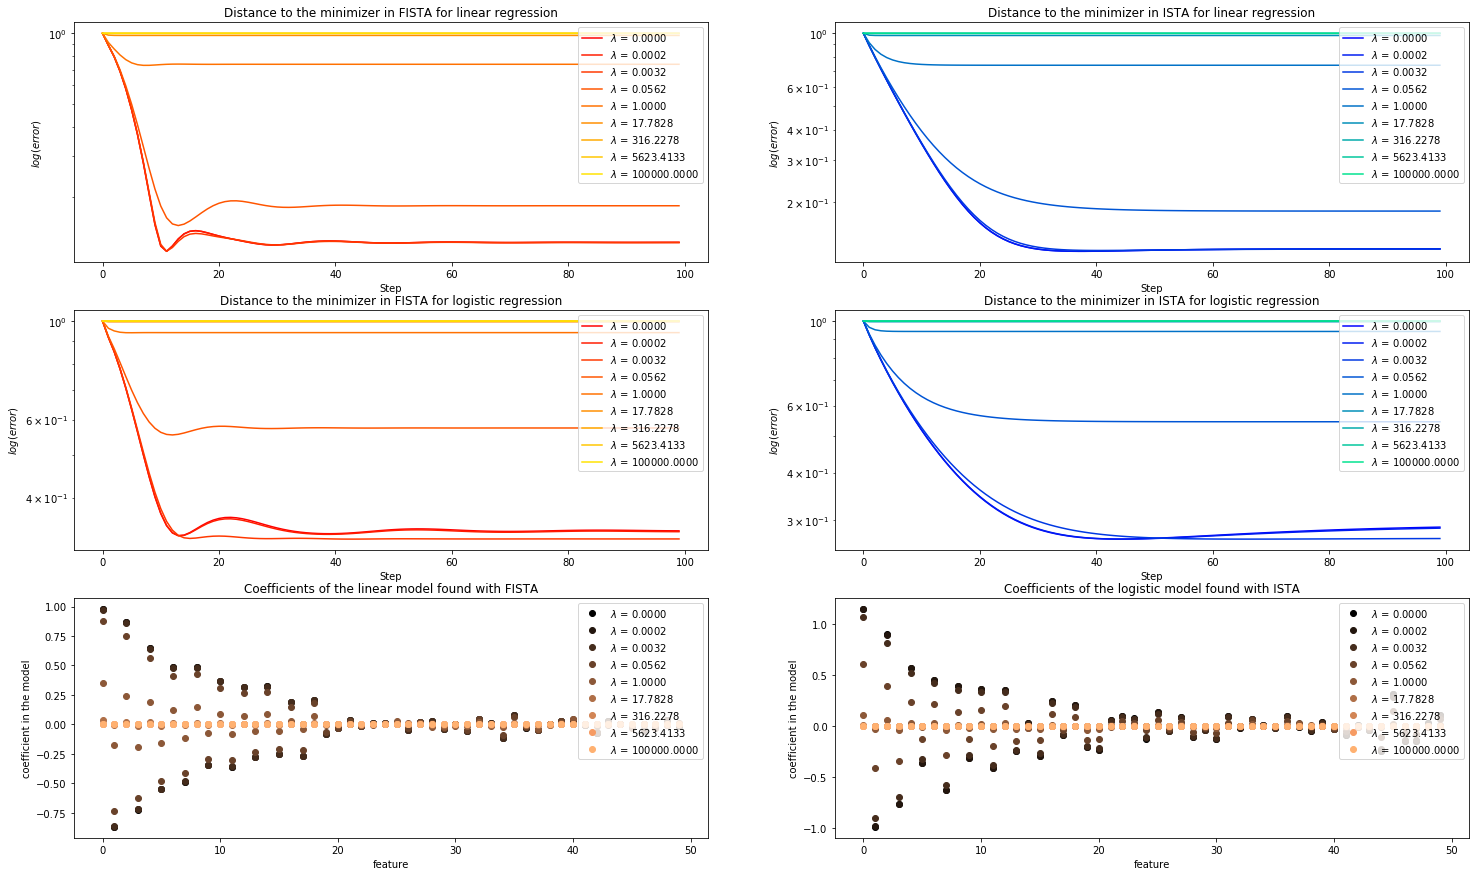

In [88]:
penalizations = np.logspace(start=-5, stop=5, base=10.0, num=9)
xx_fista = np.zeros((len(penalizations), n_features))
xx_ista = np.zeros((len(penalizations), n_features))
verbose = False

cm = plt.get_cmap("autumn")
colors = [cm(x) for x in np.arange(start=0, stop=1, step= 1./len(penalizations))]

n_max = 100

# For linear regression and FISTA
fig, (ax1, ax2, ax3) = plt.subplots(3, 2, figsize=(25, 15))

A,b = simu_linreg(coefs)
L = lip_linreg(A)
f = lambda x: loss_linreg(x, A, b)
grad_f = lambda x: grad_linreg(x, A, b)
for i, penalization in enumerate(penalizations):
    xx_fista[i], _, err_fista = fista(x0=x0, f=f, grad_f=grad_f, g=ridge, prox_g=prox_ridge, L=L, λ=penalization, n_iter=1000, x_true=coefs, verbose=verbose)
    ax1[0].plot(range(n_max), err_fista[:n_max], '-', label="$\lambda$ = " + "%0.4f"%penalization, color=colors[i])

ax1[0].legend(loc="upper right")
ax1[0].set_xlabel("Step")
ax1[0].set_ylabel("$log(error)$")
ax1[0].set_title("Distance to the minimizer in FISTA for linear regression")
ax1[0].set_yscale("log")

cm = plt.get_cmap("winter")
colors = [cm(x) for x in np.arange(start=0, stop=1, step= 1./len(penalizations))]

# For linear regression and ISTA
plt.figure(figsize=(16, 6))

for i, penalization in enumerate(penalizations):
    xx_ista[i], _, err_ista = ista(x0=x0, f=f, grad_f=grad_f, g=ridge, prox_g=prox_ridge, L=L, λ=penalization, n_iter=1000, x_true=coefs, verbose=verbose)
    ax1[1].plot(range(n_max), err_ista[:n_max], '-', label="$\lambda$ = " + "%.4f"%penalization, color=colors[i])

ax1[1].legend(loc="upper right")
ax1[1].set_xlabel("Step")
ax1[1].set_ylabel("$log(error)$")
ax1[1].set_title("Distance to the minimizer in ISTA for linear regression")
ax1[1].set_yscale("log")


# Resulting minimizers
cm = plt.get_cmap("copper")
colors = [cm(x) for x in np.arange(start=0, stop=1, step= 1./len(penalizations))]
plt.figure(figsize=(16, 10))
nbplots = len(penalizations)
for i in range(nbplots):
    ax3[0].plot(xx_fista[i], 'o', label="$\lambda$ = " + "%0.4f"%penalizations[i], color= colors[i])

ax3[0].legend(loc="upper right")
ax3[0].set_xlabel("feature")
ax3[0].set_ylabel("coefficient in the model")
ax3[0].set_title("Coefficients of the linear model found with FISTA")

# For logistic regression and FISTA
cm = plt.get_cmap("autumn")
colors = [cm(x) for x in np.arange(start=0, stop=1, step= 1./len(penalizations))]
A,b = simu_logreg(coefs)
L = lip_logreg(A)
f = lambda x: loss_logreg(x, A, b)
grad_f = lambda x: grad_logreg(x, A, b)
for i, penalization in enumerate(penalizations):
    xx_fista[i], _, err_fista = fista(x0=x0, f=f, grad_f=grad_f, g=ridge, prox_g=prox_ridge, L=L, λ=penalization, n_iter=1000, x_true=coefs, verbose=verbose)
    ax2[0].plot(range(n_max), err_fista[:n_max], '-', label="$\lambda$ = " + "%0.4f"%penalization, color=colors[i])

ax2[0].legend(loc="upper right")
ax2[0].set_xlabel("Step")
ax2[0].set_ylabel("$log(error)$")
ax2[0].set_title("Distance to the minimizer in FISTA for logistic regression")
ax2[0].set_yscale("log")

# For logistic regression and ISTA
cm = plt.get_cmap("winter")
colors = [cm(x) for x in np.arange(start=0, stop=1, step= 1./len(penalizations))]
A,b = simu_logreg(coefs)
L = lip_logreg(A)
f = lambda x: loss_logreg(x, A, b)
grad_f = lambda x: grad_logreg(x, A, b)
for i, penalization in enumerate(penalizations):
    xx_ista[i], _, err_ista = ista(x0=x0, f=f, grad_f=grad_f, g=ridge, prox_g=prox_ridge, L=L, λ=penalization, n_iter=1000, x_true=coefs, verbose=verbose)
    ax2[1].plot(range(n_max), err_ista[:n_max], '-', label="$\lambda$ = " + "%0.4f"%penalization, color=colors[i])

ax2[1].legend(loc="upper right")
ax2[1].set_xlabel("Step")
ax2[1].set_ylabel("$log(error)$")
ax2[1].set_title("Distance to the minimizer in ISTA for logistic regression")
ax2[1].set_yscale("log")

# Resulting minimizers
cm = plt.get_cmap("copper")
colors = [cm(x) for x in np.arange(start=0, stop=1, step= 1./len(penalizations))]
plt.figure(figsize=(16, 6))
nbplots = len(penalizations)
for i in range(nbplots):
    ax3[1].plot(xx_fista[i], 'o', label="$\lambda$ = " + "%0.4f"%penalizations[i], color= colors[i])

ax3[1].legend(loc="upper right")
ax3[1].set_xlabel("feature")
ax3[1].set_ylabel("coefficient in the model")
ax3[1].set_title("Coefficients of the logistic model found with ISTA")

plt.tight_layout()
plt.show()
# cm = plt.get_cmap("")
# colors = [cm(x) for x in np.arange(start=0, stop=1, step= 1./len(penalizations))]

<div class="alert alert-warning">
    <b>Answer</b>:
     <ul>
        <h5> Impact of the regularization level</h5>
        <p> - The higher the value of the penalization, the higher the final error. <br> - When the value of the penalization is high, the coefficients of the minimizer are shrinked to zero, as the mathematical expression of the proximal operator shows: xmin is a function of 1/(1+s). Because of this, when we initialize the vector x0 with zeros, we are closer to the final minimizer if s is high. <br> - Regarding the speed of the algorithm, we notice that the slope of each algorithm is bigger when  the regularization is smaller: we get faster to the final value. <br> - FISTA behaves similarly to ISTA, but "undulates".</p>
    </ul>
</div>

____
Let us study the impact of the regularization type.
The code below is ugly and not interesting, **please skip directly to the chart it outputs.**

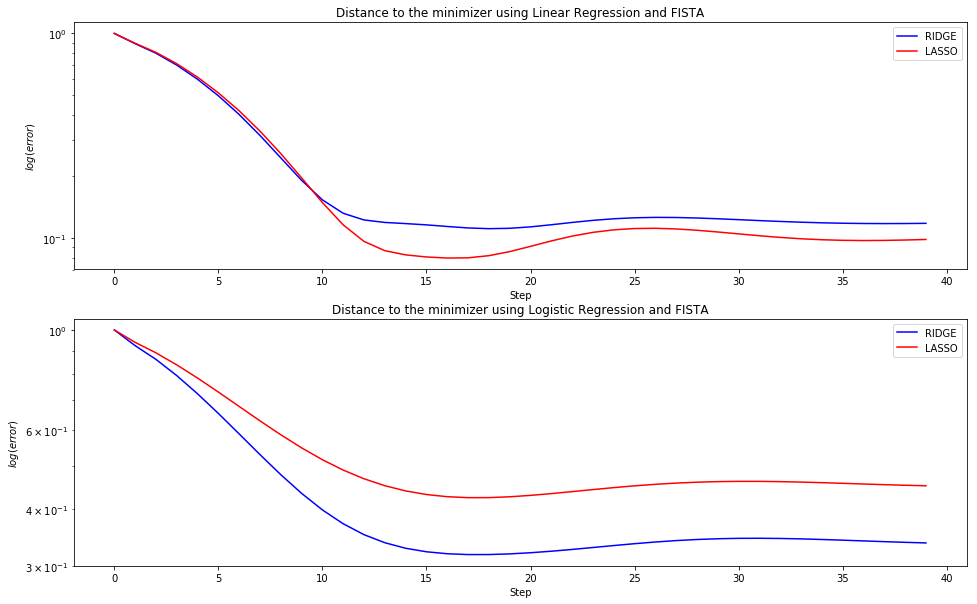

In [95]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

###################################################################
# Linear Regression (LASSO and RIDDGE)
###################################################################
A,b = simu_linreg(coefs)
L = lip_linreg(A)
f = lambda x: loss_linreg(x, A, b)
grad_f = lambda x: grad_linreg(x, A, b)
_, _, err_fista = fista(x0=x0, f=f, grad_f=grad_f, g=ridge, prox_g=prox_ridge, L=L, λ=λ, n_iter=n_iter, x_true=coefs, verbose=verbose)
ax1.plot(range(n_iter), err_fista[:n_iter], 'b-', label="RIDGE")
_, _, err_fista = fista(x0=x0, f=f, grad_f=grad_f, g=lasso, prox_g=prox_lasso, L=L, λ=λ, n_iter=n_iter, x_true=coefs, verbose=verbose)
ax1.plot(range(n_iter), err_fista[:n_iter], 'r-', label="LASSO")

ax1.legend(loc="upper right")
ax1.set_xlabel("Step")
ax1.set_ylabel("$log(error)$")
ax1.set_title("Distance to the minimizer using Linear Regression and FISTA")
ax1.set_yscale("log")

###################################################################
# Logistic Regression (LASSO and RIDDGE)
###################################################################
A,b = simu_logreg(coefs)
L = lip_logreg(A)
f = lambda x: loss_logreg(x, A, b)
grad_f = lambda x: grad_logreg(x, A, b)
_, _, err_fista = fista(x0=x0, f=f, grad_f=grad_f, g=ridge, prox_g=prox_ridge, L=L, λ=λ, n_iter=n_iter, x_true=coefs, verbose=verbose)
ax2.plot(range(n_iter), err_fista[:n_iter], 'b-', label="RIDGE")
_, _, err_fista = fista(x0=x0, f=f, grad_f=grad_f, g=lasso, prox_g=prox_lasso, L=L, λ=λ, n_iter=n_iter, x_true=coefs, verbose=verbose)
ax2.plot(range(n_iter), err_fista[:n_iter], 'r-', label="LASSO")

ax2.legend(loc="upper right")
ax2.set_xlabel("Step")
ax2.set_ylabel("$log(error)$")
ax2.set_title("Distance to the minimizer using Logistic Regression and FISTA")
ax2.set_yscale("log")


<div class="alert alert-warning">
    <b>Answer</b>:
     <ul>
        <h5> Impact of the regularization type</h5>
        <p> - When using logistic regression we notive that LASSO is faster than RIDGE and lead to a solution which is further away from the objective. It makes sense as LASSO provides a solution which is sparse. We saw that several coefficients are set to zero quickly, which reduces the number of coefficients  to compute. Of course, with such a bias, the final result is not as close to the final solution as with the RIDGE method</p>
    <p> - When using linear regression we observe similar results, but at some point Lasso provides a better estimation. Which we do not explain..</p>
    </ul>
</div>